<a href="https://colab.research.google.com/github/LeninCar/approach-asp-jssp/blob/main/approach_asp_jssp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q xgboost
!pip install -q pandas scikit-learn numpy openpyxl

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from xgboost import XGBClassifier

import joblib
import os

# Semilla de reproducibilidad
SEED = 24
np.random.seed(SEED)


Se carga el archivo del dataset (.xlsx/.csv) con comprobaciones básicas y se visualiza el DataFrame.

In [3]:

path = "data.xlsx"

if os.path.exists(path):
    if path.lower().endswith((".xlsx", ".xls")):
        df = pd.read_excel(path, sheet_name=0)
    elif path.lower().endswith(".csv"):
        df = pd.read_csv(path)
    else:
        raise ValueError("Formato no soportado. Usa .xlsx, .xls o .csv")
else:
    raise FileNotFoundError(f"No se encontró el archivo en: {path}")

print(df.shape)
# df.head()


(9720, 26)


Se definen las columnas de algoritmos (vendrían siendo los posibles targets) y numéricas, y revisa que todas existan en el DataFrame.

In [4]:
ALG_COLS = ['cplex', 'gurobi', 'gecode']
# ALG_COLS = ['cplex', 'gurobi', 'gecode', 'ga', 'pso'] //Solvers adicinoales en el dataset

ALGO_NAMES = ALG_COLS

NUM_COLS = [
    'jobs', 'machines', 'rddd', 'speed',
    'min_window', 'max_window', 'mean_window',
    'overlap',
    'min_processing_time_value', 'max_processing_time_value', 'mean_processing_time_value',
    'min_energy_value', 'max_energy_value', 'mean_energy_value'
]

for col in ALG_COLS + NUM_COLS:
    if col not in df.columns:
        print("Falta la columna en df:", col)


Se filtran filas sin NaN en algoritmos, se define una fucniónn para determinar el algoritmo con menor valor y se muestra la distribución de clases.

In [5]:
# Nos quedamos con filas donde todos los algoritmos tienen valor (no NaN)
df_clf = df.dropna(subset=ALG_COLS).copy()
print("Filas usadas para clasificación:", df_clf.shape[0])

def best_algo_index(row):
    # argmin sobre los valores de los algoritmos
    return np.argmin(row[ALG_COLS].values)

#El valor de la función objetivo menor es el índice del mejor algoritmo

y = df_clf.apply(best_algo_index, axis=1).values
X = df_clf[NUM_COLS].copy()

print("índice del algoritmo):")
unique, counts = np.unique(y, return_counts=True)
for idx, c in zip(unique, counts):
    print(f"  Clase {idx} ({ALGO_NAMES[idx]}): {c} instancias")


Filas usadas para clasificación: 4203
índice del algoritmo):
  Clase 0 (cplex): 1998 instancias
  Clase 1 (gurobi): 2091 instancias
  Clase 2 (gecode): 114 instancias


Se crea un pipeline para imputar y escalar, y separa los datos en 80/20 manteniendo proporciones.

In [6]:
from sklearn.model_selection import train_test_split

#A los valores nan les asignamos la mediana de la columna y los escalamos
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

preprocess = ColumnTransformer([
    ("num", num_pipe, NUM_COLS),
], remainder="drop")

#20% para test, 80% para train,
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=SEED,
    stratify=y #mantiene la misma proporción de clases en train y test
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (3362, 14) Test: (841, 14)


Se construye un diccionario con varios clasificadores (LogReg, Naive Bayes, Árboles, KNN, Random Forest, XGBoost y MLP).
Cada modelo se integra en un pipeline que incluye el preprocesamiento definido previamente.
Luego, se aplica validación cruzada estratificada de 5 folds para medir la exactitud de cada clasificador.
Finalmente, los resultados se ordenan por accuracy promedio para identificar el mejor modelo.

In [7]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline

models = {
    "LogReg": LogisticRegression(random_state=SEED),
    "GNB": GaussianNB(),
    "Tree": DecisionTreeClassifier(random_state=SEED),
    "KNN": KNeighborsClassifier(),
    "RF": RandomForestClassifier(random_state=SEED),
    "XGB": XGBClassifier(random_state=SEED),
    "MLP": MLPClassifier(random_state=SEED),
}


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

cv_results = []

for name, model in models.items():
    pipe = Pipeline([
        ("prep", preprocess),
        ("model", model)
    ])
    scores = cross_val_score(
        pipe, X_train, y_train,
        cv=cv,
        scoring="accuracy",
        n_jobs=-1
    )
    cv_results.append((name, scores.mean(), scores.std()))
    print(f"{name}: accuracy CV = {scores.mean():.4f} ± {scores.std():.4f}")

cv_results = sorted(cv_results, key=lambda x: x[1], reverse=True)

print("\nModelos organizados por accuracy CV:")
for name, mean_acc, std_acc in cv_results:
    print(f"{name}: {mean_acc:.4f} ± {std_acc:.4f}")


LogReg: accuracy CV = 0.8296 ± 0.0044
GNB: accuracy CV = 0.6017 ± 0.0257
Tree: accuracy CV = 0.7930 ± 0.0141
KNN: accuracy CV = 0.8364 ± 0.0103
RF: accuracy CV = 0.8337 ± 0.0060
XGB: accuracy CV = 0.8257 ± 0.0076
MLP: accuracy CV = 0.8447 ± 0.0099

Modelos organizados por accuracy CV:
MLP: 0.8447 ± 0.0099
KNN: 0.8364 ± 0.0103
RF: 0.8337 ± 0.0060
LogReg: 0.8296 ± 0.0044
XGB: 0.8257 ± 0.0076
Tree: 0.7930 ± 0.0141
GNB: 0.6017 ± 0.0257


Se identifica el modelo con mayor accuracy promedio según la validación cruzada. Con ese modelo se construye un pipeline final que incluye el preprocesamiento y se entrena usando el conjunto de entrenamiento.

Después, se generan predicciones sobre el conjunto de test y se calcula el accuracy final para evaluar el desempeño real del modelo.

In [8]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np

# --- Elegir mejor modelo según CV ---
best_name = cv_results[0][0]
best_model = models[best_name]

print("Mejor modelo según CV:", best_name)

# --- Pipeline final ---
best_pipe = Pipeline([
    ("prep", preprocess),
    ("model", best_model)
])

best_pipe.fit(X_train, y_train)

# --- Predicciones en test ---
y_pred = best_pipe.predict(X_test)

print("\nAccuracy en test:", round(accuracy_score(y_test, y_pred), 4))

# --- Manejar el caso de clases ausentes en test ---
labels_present = np.unique(np.concatenate([y_test, y_pred]))
label_names = [ALGO_NAMES[i] for i in labels_present]

print("\nEtiquetas presentes en los datos de test:")
for idx, name in zip(labels_present, label_names):
    print(f"  Clase {idx}: {name}")

# Matriz de confusión restringida a esas clases
cm = confusion_matrix(y_test, y_pred, labels=labels_present)
print("\nMatriz de confusión (filas=real, cols=pred):")
print("Orden de clases:", label_names)
print(cm)

# Classification report coherente
print("\nReporte por clase:")
print(classification_report(
    y_test,
    y_pred,
    labels=labels_present,
    target_names=label_names
))

# precision → de las veces que predije algún solver, ¿cuántas eran realmente gurobi?

# recall → de todas las veces que era realmente algún solver ¿cuántas acerté?

# f1-score → promedio armónico entre precision y recall.

# support → cuántas instancias reales de esa clase hay en el test.


Mejor modelo según CV: MLP

Accuracy en test: 0.8419

Etiquetas presentes en los datos de test:
  Clase 0: cplex
  Clase 1: gurobi
  Clase 2: gecode

Matriz de confusión (filas=real, cols=pred):
Orden de clases: ['cplex', 'gurobi', 'gecode']
[[332  68   0]
 [ 49 365   4]
 [  0  12  11]]

Reporte por clase:
              precision    recall  f1-score   support

       cplex       0.87      0.83      0.85       400
      gurobi       0.82      0.87      0.85       418
      gecode       0.73      0.48      0.58        23

    accuracy                           0.84       841
   macro avg       0.81      0.73      0.76       841
weighted avg       0.84      0.84      0.84       841



/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Se calcula un resumen por cada solver presente en el conjunto de test, usando la matriz de confusión.

Para cada solver se obtiene:

true_best_count: cuántas veces ese solver era realmente el mejor (soporte por clase).

correct_predictions: cuántas veces el modelo lo predijo correctamente.

recall_when_best: qué tan bien identifica al solver cuando realmente es el mejor.

precision_when_predicted: qué tan confiables son las predicciones cuando el modelo escoge ese solver.

In [9]:
import pandas as pd
import numpy as np

solver_rows = []

for pos, label in enumerate(labels_present):
    name = ALGO_NAMES[label]

    row = cm[pos, :]   # fila: instancias donde el solver real es "name"
    col = cm[:, pos]   # columna: instancias donde el modelo predijo "name"

    support_true = row.sum()   # cuántas veces ese solver era el mejor de verdad
    correct = cm[pos, pos]     # cuántas veces lo acerté

    # "accuracy del solver" cuando él es el mejor (= recall)
    recall_true_best = correct / support_true if support_true > 0 else np.nan

    # precisión: de todas las veces que lo predije, cuántas eran correctas
    predicted_as = col.sum()
    precision_when_predicted = correct / predicted_as if predicted_as > 0 else np.nan

    solver_rows.append({
        "solver": name,
        "true_best_count": int(support_true),
        "correct_predictions": int(correct),
        "recall_when_best": recall_true_best,
        "precision_when_predicted": precision_when_predicted
    })

solver_df = pd.DataFrame(solver_rows)
print(solver_df)


   solver  true_best_count  correct_predictions  recall_when_best  \
0   cplex              400                  332          0.830000   
1  gurobi              418                  365          0.873206   
2  gecode               23                   11          0.478261   

   precision_when_predicted  
0                  0.871391  
1                  0.820225  
2                  0.733333  


Se define una función que recibe una nueva instancia del problema (en forma de diccionario con las características numéricas) y la convierte en un DataFrame de una sola fila.
Solo se mantienen las columnas definidas en NUM_COLS para asegurar consistencia con el modelo.

Luego, el pipeline entrenado (best_pipe) genera una predicción y se traduce el índice al nombre del solver recomendado.
  
La instancia es **sólo un ejemplo** , no cumple necesariamente con todos los valores definidos en el modelo.

In [10]:
def recomendar_solver(x_new: dict):
    """
    Recibe un diccionario con las características NUM_COLS de una nueva instancia
    y devuelve el solver recomendado como string (cplex / gurobi / gecode).
    """

    # Convertir el dict en un DataFrame de 1 fila
    x_df = pd.DataFrame([x_new])

    # Asegurar que solo se pasan las columnas NUM_COLS
    x_df = x_df[NUM_COLS]

    # Predecir con el pipeline entrenado
    pred = best_pipe.predict(x_df)[0]

    # Traducir índice → nombre del solver
    solver_name = ALGO_NAMES[pred]

    return solver_name


x_nueva = {
    'jobs': 10,
    'machines': 5,
    'rddd': 0,
    # 0 → sin restricciones de fechas (no hay ventanas de tiempo)
    # 1 → restricciones a nivel de job
    # 2 → restricciones a nivel de operación
    'speed': 1.0,
    'min_window': 2,
    'max_window': 10,
    'mean_window': 6,
    'overlap': 1,
    'min_processing_time_value': 1.0,
    'max_processing_time_value': 20.0,
    'mean_processing_time_value': 7.5,
    'min_energy_value': 1.0,
    'max_energy_value': 5.0,
    'mean_energy_value': 3.0,
}

solver = recomendar_solver(x_nueva)
print("Solver recomendado:", solver)



Solver recomendado: cplex


## Ejecución de una instancia usando un el solver de or-tools

Dado que se quería completar el diagrama de ejecución del artículo selecionado, tmabién se evalua la instancia con el modelo y solver de google para evaluar la instancia.

In [11]:
!pip install ortools

Implementa un modelo JSSP en OR-Tools: crea variables, aplica restricciones, minimiza el makespan y devuelve el schedule obtenido

In [12]:
import collections
from ortools.sat.python import cp_model

# Named tuples globales para reusar
task_type = collections.namedtuple("task_type", "start end interval")
assigned_task_type = collections.namedtuple(
    "assigned_task_type", "start job index duration"
)

def solve_jobshop_ortools(jobs_data):
    """
    Resuelve un Job Shop Scheduling Problem usando OR-Tools CP-SAT.

    jobs_data: lista de jobs, cada job es lista de tuplas (machine_id, processing_time)
    Ejemplo:
        jobs_data = [
            [(0, 3), (1, 2), (2, 2)],  # Job0
            [(0, 2), (2, 1), (1, 4)],  # Job1
            [(1, 4), (2, 3)],          # Job2
        ]
    """

    machines_count = 1 + max(task[0] for job in jobs_data for task in job)
    all_machines = range(machines_count)
    horizon = sum(task[1] for job in jobs_data for task in job)

    model = cp_model.CpModel()

    all_tasks = {}
    machine_to_intervals = collections.defaultdict(list)

    # Crear variables
    for job_id, job in enumerate(jobs_data):
        for task_id, task in enumerate(job):
            machine, duration = task
            suffix = f"_{job_id}_{task_id}"
            start_var = model.new_int_var(0, horizon, "start" + suffix)
            end_var = model.new_int_var(0, horizon, "end" + suffix)
            interval_var = model.new_interval_var(
                start_var, duration, end_var, "interval" + suffix
            )
            all_tasks[job_id, task_id] = task_type(
                start=start_var, end=end_var, interval=interval_var
            )
            machine_to_intervals[machine].append(interval_var)

    # No solapamiento por máquina
    for machine in all_machines:
        model.add_no_overlap(machine_to_intervals[machine])

    # Precedencias dentro de cada job
    for job_id, job in enumerate(jobs_data):
        for task_id in range(len(job) - 1):
            model.add(
                all_tasks[job_id, task_id + 1].start
                >= all_tasks[job_id, task_id].end
            )

    # Makespan
    obj_var = model.new_int_var(0, horizon, "makespan")
    model.add_max_equality(
        obj_var,
        [all_tasks[job_id, len(job) - 1].end for job_id, job in enumerate(jobs_data)],
    )
    model.minimize(obj_var)

    # Resolver
    solver = cp_model.CpSolver()
    status = solver.solve(model)

    if status not in (cp_model.OPTIMAL, cp_model.FEASIBLE):
        print("No solution found.")
        return {
            "status": "infeasible",
            "makespan": None,
            "schedule": None,
            "stats": {
                "conflicts": solver.num_conflicts,
                "branches": solver.num_branches,
                "wall_time": solver.wall_time,
            },
        }

    # Reconstruir solución
    assigned_jobs = collections.defaultdict(list)
    for job_id, job in enumerate(jobs_data):
        for task_id, task in enumerate(job):
            machine = task[0]
            assigned_jobs[machine].append(
                assigned_task_type(
                    start=solver.value(all_tasks[job_id, task_id].start),
                    job=job_id,
                    index=task_id,
                    duration=task[1],
                )
            )

    schedule = {}
    for machine in all_machines:
        assigned_jobs[machine].sort()
        schedule[machine] = [
            {
                "job": t.job,
                "task": t.index,
                "start": t.start,
                "end": t.start + t.duration,
                "duration": t.duration,
            }
            for t in assigned_jobs[machine]
        ]

    result = {
        "status": "feasible",
        "makespan": solver.objective_value,
        "schedule": schedule,
        "stats": {
            "conflicts": solver.num_conflicts,
            "branches": solver.num_branches,
            "wall_time": solver.wall_time,
        },
    }
    return result


In [13]:
def ejecutar_instancia_con_ortools(jobs_data, features_dict):
    """
    jobs_data: estructura detallada para OR-Tools.
    features_dict: diccionario con las features NUM_COLS para el selector.

    Devuelve:
      - nombre del solver recomendado por ML
      - resultado de OR-Tools (makespan, schedule, stats)
    """
    solver_recomendado = recomendar_solver(features_dict)
    print(f"Selector de algoritmos recomienda usar: {solver_recomendado}")

    print("Resolviendo la instancia con OR-Tools (CP-SAT) como backend...\n")
    result = solve_jobshop_ortools(jobs_data)

    return solver_recomendado, result


In [14]:
import numpy as np

jobs_data = [
    [(0, 3), (1, 2), (2, 2)],  # Job0
    [(0, 2), (2, 1), (1, 4)],  # Job1
    [(1, 4), (2, 3)],          # Job2
]

def extraer_features_desde_jobs(jobs_data):
    # Número de jobs
    num_jobs = len(jobs_data)

    # Máquinas distintas y tiempos de procesamiento
    machines = set()
    processing_times = []
    for job in jobs_data:
        for m, p in job:
            machines.add(m)
            processing_times.append(p)

    num_machines = len(machines)
    processing_times = np.array(processing_times, dtype=float)

    # Stats de tiempos de procesamiento
    min_pt = float(processing_times.min())
    max_pt = float(processing_times.max())
    mean_pt = float(processing_times.mean())

    features = {
    'jobs': num_jobs,                       # |J|
    'machines': num_machines,               # |M|
    'rddd': 0.0,                            # sin R/D → tipo 0
    'speed': 1.0,                           # una sola velocidad

    # ventanas de tiempo (no existen → -1 según el paper)
    'min_window': -1.0,
    'max_window': -1.0,
    'mean_window': -1.0,
    'overlap': -1.0,

    # tiempos de procesamiento (sí calculados a partir de P)
    'min_processing_time_value': min_pt,
    'max_processing_time_value': max_pt,
    'mean_processing_time_value': mean_pt,

    # energía (no modelas)
    'min_energy_value': -1.0,
    'max_energy_value': -1.0,
    'mean_energy_value': -1.0,
    }


    return features


# 1) Extraer features de la instancia
features_dict = extraer_features_desde_jobs(jobs_data)

# 2) Ejecutar el pipeline: selector + OR-Tools
solver_rec, res = ejecutar_instancia_con_ortools(jobs_data, features_dict)

# 3) Imprimir resultados de forma ordenada
print("Features de la instancia:")
for k, v in features_dict.items():
    print(f"  {k}: {v}")

print("\nSolver recomendado por el selector (histórico):", solver_rec)
print("\nResultado de OR-Tools en esta instancia:")
print("  Makespan:", res["makespan"])

print("\nSchedule por máquina:")
for m, tareas in res["schedule"].items():
    print(f"  Máquina {m}:")
    for t in tareas:
        print(f"    Job {t['job']} - Task {t['task']} | "
              f"start={t['start']}, end={t['end']}, dur={t['duration']}")


Selector de algoritmos recomienda usar: cplex
Resolviendo la instancia con OR-Tools (CP-SAT) como backend...

Features de la instancia:
  jobs: 3
  machines: 3
  rddd: 0.0
  speed: 1.0
  min_window: -1.0
  max_window: -1.0
  mean_window: -1.0
  overlap: -1.0
  min_processing_time_value: 1.0
  max_processing_time_value: 4.0
  mean_processing_time_value: 2.625
  min_energy_value: -1.0
  max_energy_value: -1.0
  mean_energy_value: -1.0

Solver recomendado por el selector (histórico): cplex

Resultado de OR-Tools en esta instancia:
  Makespan: 11.0

Schedule por máquina:
  Máquina 0:
    Job 1 - Task 0 | start=0, end=2, dur=2
    Job 0 - Task 0 | start=2, end=5, dur=3
  Máquina 1:
    Job 2 - Task 0 | start=0, end=4, dur=4
    Job 0 - Task 1 | start=5, end=7, dur=2
    Job 1 - Task 2 | start=7, end=11, dur=4
  Máquina 2:
    Job 1 - Task 1 | start=2, end=3, dur=1
    Job 2 - Task 1 | start=4, end=7, dur=3
    Job 0 - Task 2 | start=7, end=9, dur=2


## 2. Problem Description and Model Formulation
## 3. Algorithm Selector  

### 3.1 Feature Processing  
Estas secciones se omiten porque ya contamos con un dataset previamente construido y con todas las características procesadas. Por tanto, no fue necesario realizar extracción ni ingeniería de características adicional.

---

## 3.2 Machine Learning Models  

Se implementaron los modelos descritos en el paper, utilizando solo como hiperparámetro el valor semilla:

- **LogReg** (Logistic Regression)  
- **GNB** (Gaussian Naive Bayes)  
- **Tree** (Decision Tree)  
- **KNN** (K-Nearest Neighbors)  
- **RF** (Random Forest)  
- **XGB** (XGBoost)  
- **MLP** (Multilayer Perceptron)

---

## Hardware and Software Configuration

- **Procesador:** AMD Ryzen 7 5700G with Radeon Graphics, 3.801 MHz  
- **Cores:** 8 núcleos, 16 hilos lógicos  
- **RAM:** 32 GB  
- **Python:** 3.12.8  

---

## Results

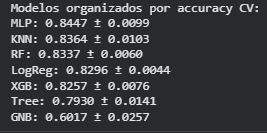

### Confusion Matrix

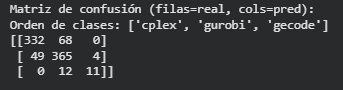

## Observaciones

Obserevaciones y notas proceso y/o implemtación

- Aún no se ha implementado el modelo matemático para la resolución del JSSP usando los solver **(Gurobi, Cplex y Gecode)** debido a limitraciones en el licenciamiento, Por ahora *mejor solución encontrada por el solver seleccionado*, se indica pero la ejecución es con el solver de Google OR-TOOLS:

  **“Developing an Algorithm Selector for Green Configuration in Scheduling Problems”**  
  https://arxiv.org/pdf/2409.08641

- En esta implementación, el modelo con mejor desempeño fue **MLP**, a diferencia del paper donde **XGBoost** obtuvo el mejor rendimiento.  
  Las diferencias pueden deberse a:
  - el dataset usado,  
  - variaciones en hiperparámetros,  
  - tamaño de la muestra,  
  - proceso de entrenamiento.
- **Exactitud alcanzada de cross-validation:** **84.47%**
- **Exactitud alcanzada con los valores testeados:** **84.19%**

